### Experimenting with pymc and SVGD

I just installed pymc according to this website (https://www.pymc.io/projects/docs/en/latest/installation.html) in a new environment

In [8]:
import pymc as pm

In [9]:
# import
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Wisconsin Breast Cancer (Diagnostic) Dataset

We got this one suggested. The advantage is that it is directly available via sklearn. The disadvantage is maybe that with 30 there are a lot of features.

**Features:** 30 (real-valued inputs)

**Instances:** 569

**Problem:** Predict whether the cancer is benign or malignant based on cell nucleus characteristics.

**Benefits:** Offers a binary classification problem with more features than the Pima Indians dataset, allowing for a deeper exploration of feature relationships using logistic regression.

In [10]:
# Load the dataset
data = load_breast_cancer()

# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target

# Display the first few rows of the DataFrame, only 3 as the output would be a bit long otherwise
print(df.head(3))

# Show the shape of the DataFrame to verify
print("Data shape:", df.shape)

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   
1                 0.05667  ...          23.41            158.8      1956.0   
2                 0.05999  ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Information on SVGD with can be found here: https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.SVGD.html

Before using the breast cancer data set, let's try it out with artificial data

### Trying PyMC out for the first time

In the following, the code just generates some artifical linear data and then defines a PyMC model with SVGD to fit the target distribution. In the end, the slope and intercept of 1000 samples is plotted

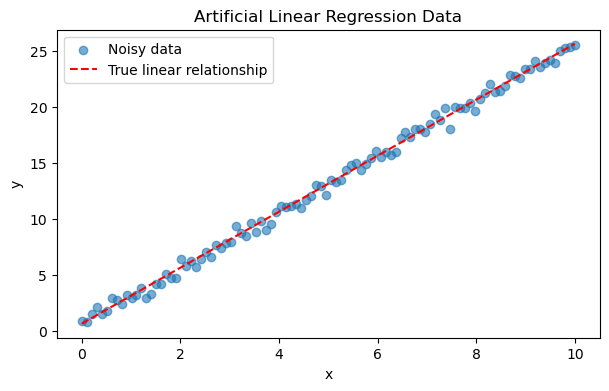

In [12]:
# Step 1: Generate Artificial Data
# We will create a simple linear regression dataset
np.random.seed(42)  # For reproducibility
x = np.linspace(0, 10, 100)  # 100 data points from 0 to 10
true_slope = 2.5
true_intercept = 0.65
# Generate noise
noise = np.random.normal(scale=0.5, size=len(x))
# Generate y values based on the linear model y = mx + c + noise
y = true_slope * x + true_intercept + noise

# Plotting the generated data
plt.figure(figsize=(7, 4))
plt.scatter(x, y, alpha=0.6, label='Noisy data')
plt.plot(x, true_slope * x + true_intercept, 'r--', label='True linear relationship')
plt.title('Artificial Linear Regression Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [13]:
# Step 2: Define the PyMC Model
# Here we define a Bayesian model with priors for slope and intercept, and a likelihood for observed data
with pm.Model() as model:
    # Priors for the unknown model parameters
    slope = pm.Normal('slope', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=slope * x + intercept, sigma=0.5, observed=y)

    # Step 3: Set up SVGD
    # We use SVGD for Bayesian inference to approximate the posterior distribution of slope and intercept
    svgd = pm.SVGD(n_particles=100, jitter=0.1, model=model)
    
    # Step 4: Run SVGD
    # We perform the inference over 10,000 iterations to adjust particles to fit the target distribution
    approx = svgd.fit(10000)

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

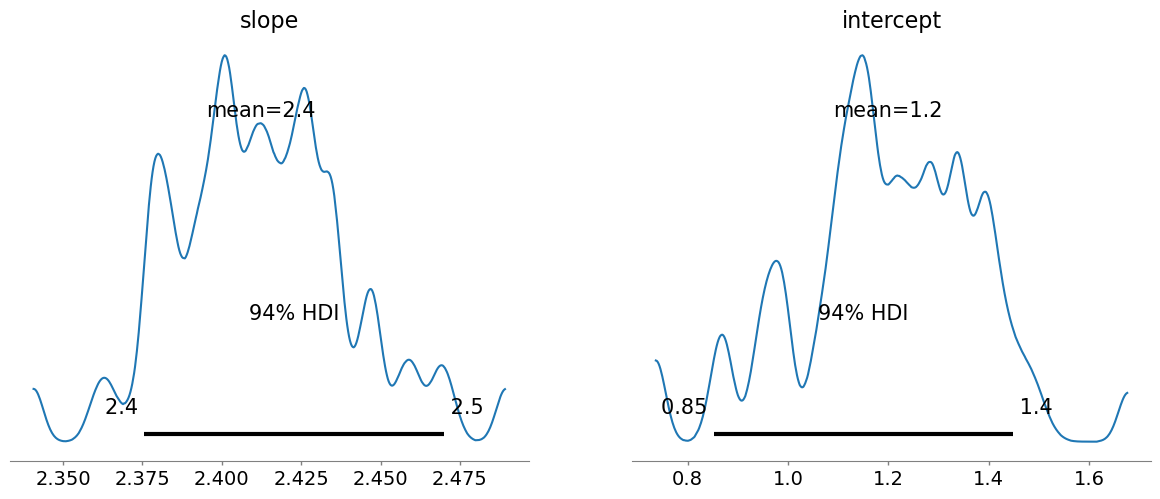

In [18]:
# Step 5: Sample from the Approximate Posterior
# samples from the distributions of slope and intercept
trace = approx.sample(1000)

# Step 6: Visualize the Results
# plot the posterior distributions of the slope and the intercept
pm.plot_posterior(trace, var_names=['slope', 'intercept'])
plt.show()